In [17]:

import pandas as pd
import math

import trueskill

from elosports.elo import Elo

import prepare_game_data
import evaluate
import elo
import nfl_trueskill
import matplotlib.pyplot as plt

In [18]:
df = prepare_game_data.download_data()
df.head()

,game_id,season,game_type,week,gameday,weekday,gametime,away_team,away_score,home_team,...,wind,away_qb_id,home_qb_id,away_qb_name,home_qb_name,away_coach,home_coach,referee,stadium_id,stadium
0,1999_01_MIN_ATL,1999,REG,1,1999-09-12,Sunday,NaN,MIN,17.0,ATL,...,NaN,00-0003761,00-0002876,Randall Cunningham,Chris Chandler,Dennis Green,Dan Reeves,Gerry Austin,ATL00,Georgia Dome
1,1999_01_KC_CHI,1999,REG,1,1999-09-12,Sunday,NaN,KC,17.0,CHI,...,12.0,00-0006300,00-0010560,Elvis Grbac,Shane Matthews,Gunther Cunningham,Dick Jauron,Phil Luckett,CHI98,Soldier Field
2,1999_01_PIT_CLE,1999,REG,1,1999-09-12,Sunday,NaN,PIT,43.0,CLE,...,12.0,00-0015700,00-0004230,Kordell Stewart,Ty Detmer,Bill Cowher,Chris Palmer,Bob McElwee,CLE00,Cleveland Browns Stadium
3,1999_01_OAK_GB,1999,REG,1,1999-09-12,Sunday,NaN,OAK,24.0,GB,...,10.0,00-0005741,00-0005106,Rich Gannon,Brett Favre,Jon Gruden,Ray Rhodes,Tony Corrente,GNB00,Lambeau Field
4,1999_01_BUF_IND,1999,REG,1,1999-09-12,Sunday,NaN,BUF,14.0,IND,...,NaN,00-0005363,00-0010346,Doug Flutie,Peyton Manning,Wade Phillips,Jim Mora,Ron Blum,IND99,RCA Dome


In [19]:
df = prepare_game_data.get_historical_games(df)
teams = prepare_game_data.get_all_teams(df)
df = prepare_game_data.create_team_histories(df)
df.head()

,game_id,season,game_type,week,gameday,weekday,gametime,away_team,away_score,home_team,...,stadium_id,stadium,team,wins_before,losses_before,draws_before,team_away,wins_before_away,losses_before_away,draws_before_away
0,1999_01_MIN_ATL,1999,REG,1,1999-09-12,Sunday,NaN,MIN,17.0,ATL,...,ATL00,Georgia Dome,ATL,0,0,0,MIN,0,0,0
1,1999_01_KC_CHI,1999,REG,1,1999-09-12,Sunday,NaN,KC,17.0,CHI,...,CHI98,Soldier Field,CHI,0,0,0,KC,0,0,0
2,1999_01_PIT_CLE,1999,REG,1,1999-09-12,Sunday,NaN,PIT,43.0,CLE,...,CLE00,Cleveland Browns Stadium,CLE,0,0,0,PIT,0,0,0
3,1999_01_OAK_GB,1999,REG,1,1999-09-12,Sunday,NaN,OAK,24.0,GB,...,GNB00,Lambeau Field,GB,0,0,0,OAK,0,0,0
4,1999_01_BUF_IND,1999,REG,1,1999-09-12,Sunday,NaN,BUF,14.0,IND,...,IND99,RCA Dome,IND,0,0,0,BUF,0,0,0


In [24]:
df_training, df_val, df_test = evaluate.split_data(df, 10, proportion_val=0.6)

In [25]:
accuracy = {}
accuracy['Home'] = evaluate.evaluate_home_advantage(df_test)
accuracy['Record'] = evaluate.evaluate_record(df_test)
accuracy['Moneyline'] = evaluate.evaluate_moneyline(df_test)



## Conduct a simple grid search for optimal values of k and home field advantage in elo


In [26]:
best_metric = 0
best_k = 0
best_h = 0

for k in [10, 20, 40, 80, 100,]:
    for home_field in [0, 10, 30, 60, 80, 100]:
        result = elo.evaluate_elo(df_training, df_val, teams, k, home_field)
        if result > best_metric:
            best_metric = result
            best_k = k
            best_h = home_field

accuracy['Elo w/ Home\nAdvantage'] = elo.evaluate_elo(df_training, df_test, teams, best_k, best_h)
print(f'Max occurs for k={best_k} and home_field={best_h}: {best_metric}')
print("On test set:", accuracy['Elo w/ Home\nAdvantage'])

Max occurs for k=40 and home_field=60: 0.6451977401129944
On test set: 0.6451016635859519


## Conduct a simple grid search for optimal values of k in elo with no home field advantage


In [27]:
best_metric = 0
best_k = 0
best_h = 0

for k in [10, 20, 40, 60, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115]:
    result = elo.evaluate_elo(df_training, df_val, teams, k, 0)
    if result > best_metric:
        best_metric = result
        best_k = k
        best_h = home_field

accuracy['Elo'] = elo.evaluate_elo(df_training, df_test, teams, best_k, 0)
print(f'Max occurs for k={best_k}: {best_metric}')
print(f"On test set: {accuracy['Elo']}")

Max occurs for k=70: 0.6322033898305085
On test set: 0.6349353049907579


## Trueskill

In [29]:
best_metric = 0
best_b = 0
best_h = 0
best_t = 0

for b in [ 3, 3.5, 4, 5, 6, 7, 8]:
    for h in [0, .5, 1, 1.5, 2, 3, 4, 5, ]:
        for t in [0.001, 0.005, 0.007, .01, 0.02, .05, .07, .08333,]:
            result = nfl_trueskill.evaluate_trueskill(df_training, df_val, teams, b, h, t)
            if result > best_metric:
                best_metric = result
                best_b = b
                best_h = h
                best_t = t

accuracy['Trueskill w/ \nHome Advantage'] = nfl_trueskill.evaluate_trueskill(df_training, df_test, teams, best_b, best_h, best_t)
print(f'Max occurs for b={best_b}, homefield={best_h}, tau={best_t}: {best_metric}')
print(f"On test set:", accuracy['Trueskill w/ \nHome Advantage'])

Max occurs for b=7, homefield=4, tau=0.001: 0.6508474576271186
On test set: 0.6515711645101664


Text(0, 0.5, 'Proportion of games accurately predicted')

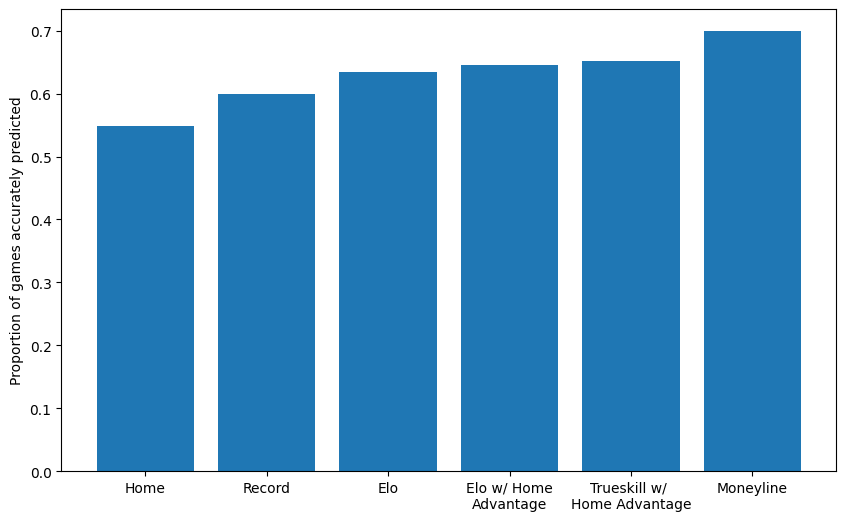

In [30]:
names = [] 
vals = []
items = accuracy.items()
items = sorted(items, key=lambda tup: tup[1])
for n, v in items:
    names.append(n)
    vals.append(v)

fig, ax = plt.subplots(figsize=(10, 6)) 
ax.bar(names, 
        vals)
ax.set_ylabel('Proportion of games accurately predicted')